In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from os import listdir
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import skimage
from skimage import transform
from skimage.transform import resize
from skimage.color import rgb2gray
import mahotas
import scipy
from scipy import misc
from scipy.misc import imresize, imread
import sklearn
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import dask
from dask.distributed import Client
from sklearn.externals import joblib
from distributed import Client, LocalCluster
from keras.preprocessing.image import img_to_array, load_img


c:\users\clyde\anaconda3\envs\dask-scipy\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
path = os.getcwd()
path = path + '\\101_ObjectCategories'
path

'C:\\Users\\clyde\\Documents\\Thinkful\\Data Science Bootcamp\\Unit-3\\Capstone\\101_ObjectCategories'

In [3]:
listdir()[1:100]
catList = listdir(path)

<h3> Extract images from folders </h3>

In [4]:
num_Folds = 50
def loadBatchImages(path,nSamples):
    catList = listdir(path)
    loadedImages = []
    loadedLabels = []
    indx = 0
    for cat in catList[1:num_Folds]:
        deepPath = path+ "\\" +cat+"\\"
        imageList = listdir(deepPath)
        print(deepPath)
        for images in imageList[0:nSamples]:                
            img = load_img(deepPath + images)
            img = img_to_array(img)/255
            img = misc.imresize(img, (244,244))
            loadedLabels.append(indx)
            loadedImages.append(img)
        indx += 1
    return loadedImages, loadedLabels

In [5]:
nSamples = 60
X_train, y_train = loadBatchImages(path,nSamples)

C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\airplanes\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\anchor\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\ant\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\BACKGROUND_Google\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\barrel\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\bass\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\beaver\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\binocular\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_ObjectCategories\bonsai\
C:\Users\clyde\Documents\Thinkful\Data Science Bootcamp\Unit-3\Capstone\101_Obj

In [6]:
x,y_index= np.unique(np.array(y_train),return_counts=True)
print(x)
print(y_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
[60 42 42 60 47 54 46 33 60 60 43 60 60 50 43 60 47 59 60 60 47 60 60 60
 50 51 57 60 52 60 60 60 60 53 60 60 60 60 60 60 45 34 34 51 60 60 42 54
 60]


<h3> Sample Image Dataset </h3>

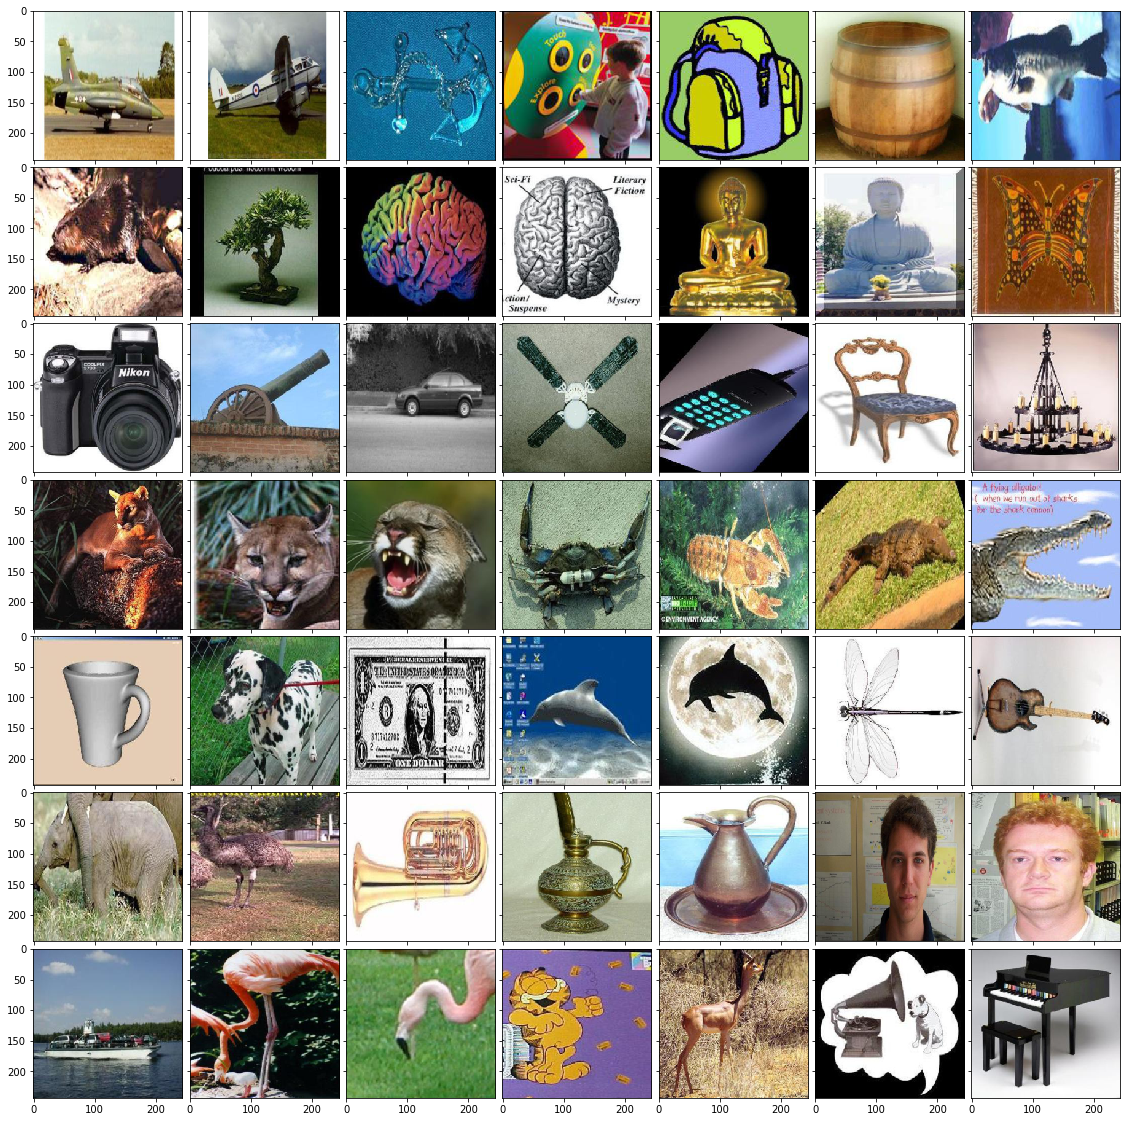

In [7]:
fig = plt.figure(1, (20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(7, 7),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(49):
    grid[i].imshow(X_train[i*50][:][:][:])  # The AxesGrid object work as a list of axes.

plt.show()

In [8]:
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [9]:
np.shape(np.array(data_train))

(1766, 244, 244, 3)

<h3> Preprocess RBG images into Grayscale for PCA feature extraction </h3>

In [10]:
n_samples_train = np.shape(data_train)[0]
data_train_gray = np.zeros(shape=(n_samples_train,244,244))
for index in range(np.shape(data_train)[0]):
    data_train_gray[index][:][:] = rgb2gray(data_train[index][:][:][:])

In [11]:
n_samples_test = np.shape(data_test)[0]
data_test_gray = np.zeros(shape=(n_samples_test,244,244))
for index in range(n_samples_test):
        data_test_gray[index][:][:]= rgb2gray(data_test[index][:][:][:])

In [12]:
np.shape(np.array(data_train_gray))

(1766, 244, 244)

In [13]:
dtrain_reshape = data_train_gray.reshape(n_samples_train,-1)

In [14]:
dtest_reshape = data_test_gray.reshape(n_samples_test,-1)

In [15]:
n_components = 150 
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(dtrain_reshape)

In [16]:
print("Projecting the input data on the eigenobjects orthonormal basis")
X_train_pca = pca.transform(dtrain_reshape)
X_test_pca = pca.transform(dtest_reshape)

Projecting the input data on the eigenobjects orthonormal basis


<h3>Extract more statistical features from images </h3>

In [17]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
def fd_haralick(image):    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick
 
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [4, 4, 4], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

In [18]:
fd_haralick(data_train[1][:][:][:]).shape


(13,)

In [19]:
fd_hu_moments(data_train[1][:][:][:]).shape

(7,)

In [20]:
fd_histogram(data_train[1][:][:][:]).shape

(64,)

<h3> Stack, scale and append statistical image features to PCA features </h3>

In [21]:
global_feature_train = np.zeros(shape=(np.shape(data_train)[0],64+7+13))
for index in range(np.shape(data_train)[0]):
    global_feature_train[index][:] = np.hstack([fd_histogram(data_train[index][:][:][:]), fd_haralick(data_train[index][:][:][:]), fd_hu_moments(data_train[index][:][:][:])])


In [22]:
global_feature_test = np.zeros(shape=(np.shape(data_test)[0],64+7+13))
for index in range(np.shape(data_test)[0]):
    global_feature_test[index][:] = np.hstack([fd_histogram(data_test[index][:][:][:]), fd_haralick(data_test[index][:][:][:]), fd_hu_moments(data_test[index][:][:][:])])
    

In [23]:
global_features_final_train = np.hstack([global_feature_train,X_train_pca])
global_features_final_test  = np.hstack([global_feature_test ,X_test_pca ])

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features_train = scaler.fit_transform(global_features_final_train)
rescaled_features_test  = scaler.fit_transform(global_features_final_test)

In [35]:
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 100 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(3000,),max_iter=200,verbose=True)
X, y = rescaled_features_train, labels_train
mlp.fit(X, y)

Iteration 1, loss = 3.93233434
Iteration 2, loss = 3.80543134
Iteration 3, loss = 3.70741753
Iteration 4, loss = 3.62455275
Iteration 5, loss = 3.53140904
Iteration 6, loss = 3.42521470
Iteration 7, loss = 3.33662864
Iteration 8, loss = 3.25925362
Iteration 9, loss = 3.17191608
Iteration 10, loss = 3.10302566
Iteration 11, loss = 3.04084410
Iteration 12, loss = 2.96050929
Iteration 13, loss = 2.92121031
Iteration 14, loss = 2.86119076
Iteration 15, loss = 2.82676895
Iteration 16, loss = 2.75009543
Iteration 17, loss = 2.72054009
Iteration 18, loss = 2.68744129
Iteration 19, loss = 2.61218741
Iteration 20, loss = 2.58568857
Iteration 21, loss = 2.54157136
Iteration 22, loss = 2.50636999
Iteration 23, loss = 2.46467097
Iteration 24, loss = 2.45284638
Iteration 25, loss = 2.40856674
Iteration 26, loss = 2.36284773
Iteration 27, loss = 2.31769330
Iteration 28, loss = 2.29213932
Iteration 29, loss = 2.26053992
Iteration 30, loss = 2.24548776
Iteration 31, loss = 2.21541290
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

<h3> Generate classification report and cross tabulation scores for MLP on test data </h3>

In [36]:
print("Predicting object names on the SVM test set")
X = rescaled_features_test
y_pred = mlp.predict(X)
print(classification_report(labels_test,y_pred, target_names=catList[1:num_Folds]))

Predicting object names on the SVM test set
                   precision    recall  f1-score   support

        airplanes       0.78      1.00      0.88        14
           anchor       0.20      0.09      0.13        11
              ant       0.08      0.10      0.09        10
BACKGROUND_Google       0.00      0.00      0.00        22
           barrel       0.00      0.00      0.00        18
             bass       0.00      0.00      0.00        23
           beaver       0.11      0.12      0.12        16
        binocular       1.00      0.18      0.31        11
           bonsai       0.23      0.12      0.16        24
            brain       0.29      0.29      0.29        21
     brontosaurus       0.05      0.07      0.06        14
           buddha       0.33      0.12      0.17        17
        butterfly       0.16      0.13      0.14        23
           camera       0.38      0.27      0.32        11
           cannon       0.17      0.23      0.19        13
         ca

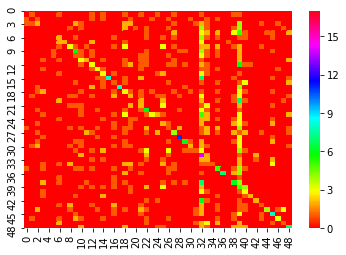

In [37]:
corr_mat = confusion_matrix(labels_test, y_pred)
sns.heatmap(corr_mat, cmap='hsv', annot_kws={'size':20})

<h3> RBM </h3>

In [39]:
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, Y = rescaled_features_train, labels_train
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################

[BernoulliRBM] Iteration 1, pseudo-likelihood = -150.33, time = 0.36s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -130.34, time = 0.36s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -128.02, time = 0.39s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -124.43, time = 0.36s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -121.73, time = 0.33s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -120.01, time = 0.35s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -118.71, time = 0.33s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -117.91, time = 0.33s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -117.01, time = 0.39s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -116.40, time = 0.38s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -116.08, time = 0.36s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -115.59, time = 0.38s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -115.09, time = 0.41s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -114.90, time = 0.32s
[BernoulliRBM] 

<h3> Fit data to Random Forest Classifier </h3>

In [29]:
X, y = rescaled_features_train, labels_train
start = time.time()
rf_clf = RandomForestClassifier(min_samples_leaf=5)
rf_clf.fit(X, y)
end = time.time()
print("Random Forest", end - start, rf_clf.score(X,y))
pred_rf = rf_clf.predict_proba(X)

Random Forest 0.6352725028991699 0.8674971687429218


In [30]:
pred_rf1 = np.argmax(pred_rf, axis=1, out=None)

In [31]:
catList = listdir(path)
X = rescaled_features_test
y_pred = rf_clf.predict(X)
print("Predicting object names on the test set")
print(classification_report(labels_test, y_pred,target_names=catList[1:num_Folds]))

Predicting object names on the test set
                   precision    recall  f1-score   support

        airplanes       0.20      0.93      0.32        14
           anchor       0.00      0.00      0.00        11
              ant       0.00      0.00      0.00        10
BACKGROUND_Google       0.11      0.05      0.06        22
           barrel       0.00      0.00      0.00        18
             bass       0.00      0.00      0.00        23
           beaver       0.00      0.00      0.00        16
        binocular       0.22      0.18      0.20        11
           bonsai       0.00      0.00      0.00        24
            brain       0.18      0.29      0.22        21
     brontosaurus       0.00      0.00      0.00        14
           buddha       0.07      0.06      0.06        17
        butterfly       0.00      0.00      0.00        23
           camera       0.14      0.36      0.21        11
           cannon       0.14      0.08      0.10        13
         car_si

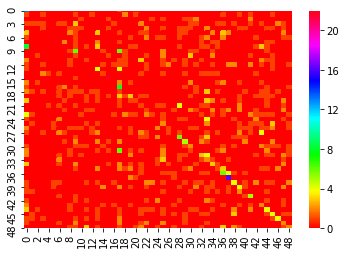

In [32]:
corr_mat = confusion_matrix(labels_test, y_pred)
sns.heatmap(corr_mat, cmap='hsv', annot_kws={'size':20})

<p> The MLP classifier outperformed the Random Forest classifier. Though not by much. The RF classifier seems to overfit the data severely. The MLP classifier achieves 26% accuracy accross all classes whereas the RF classifier achieves 16% </p>